A note book for documenting qualitative results

In [2]:
import os
import matplotlib.pyplot as plt
import torchvision
import torch
import pandas as pd
import numpy as np

from models import get_inception_transform
from data_loaders import CUB_extnded_dataset,CUB_CtoY_dataset
from IPython.display import display
from utils.notebook import display_scrollable_dataframe,plot_sailency
from sailency import get_saliency_maps,saliency_score_part

c:\Users\Andre\anaconda3\envs\CBM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Settings for the experiment your running
data_set = 'test' 

#Make the dataset
transform = get_inception_transform(mode=data_set, methode= "center")

majority_config = {'CUB_dir':r'data/CUB_200_2011',
                'split_file':r'data/train_test_val.pkl',
                'use_majority_voting':True,
                'min_class_count':0,
                'return_visibility':False}

NoN_majority_config = {'CUB_dir':r'data/CUB_200_2011',
                'split_file':r'data/train_test_val.pkl',
                'use_majority_voting':False,
                'min_class_count':0,
                'return_visibility':False}

Non_majority_data_set = CUB_extnded_dataset(mode=data_set,config_dict=NoN_majority_config,transform=transform)

concepts_name = Non_majority_data_set.consept_labels_names

#Make the majority dataset and find the mask, we use CtoY dataset so we only need to loade the image ones 
Majority_dataset = CUB_CtoY_dataset(mode=data_set,config_dict=majority_config,transform=transform)
mask = Majority_dataset.concept_mask

#Make dataloader that return non standarized images
human_tansform = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(299),torchvision.transforms.ToTensor()])
data_human = CUB_extnded_dataset(mode=data_set,config_dict=majority_config,transform=human_tansform)

#Define usefull variables
concept_names = data_human.consept_labels_names
class_names = data_human.class_labels_names
n_classes = data_human.n_classes
n_concepts = data_human.n_concepts

print(f"Number of classes: {n_classes}")
print(f"Number of concepts: {n_concepts}")

Number of classes: 200
Number of concepts: 312


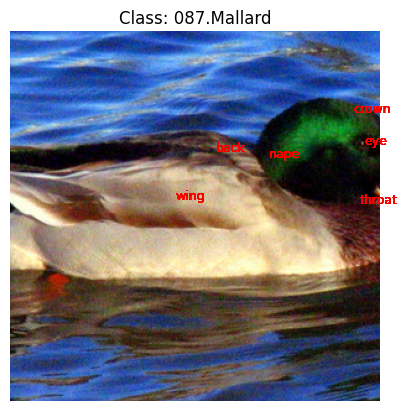

In [4]:
# Genrate the dataset
#picturer_idx = 2447
picturer_idx = 2455
#picturer_idx = 2454 #Gadwell

img ,_,Y,coordinates = data_human.__getitem__(picturer_idx)

# Show the image and the coordinates of the concepts
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Class: {class_names[torch.argmax(Y)]}")
for i in range(len(coordinates)):
    if len(coordinates[i]) > 0:

        for x,y in coordinates[i]:
            #plt.plot(x,y,'ro')
            name=concept_names[i].split("_")[1]
            if name == "forehead":
                ofset = -30

            elif name == "eye":
                ofset = 0
            else:
                ofset = 0
            
            plt.text(x+ofset,y,name,fontsize=9,color='red')
    plt.axis('off')
            
plt.size=(50,50)
plt.show()

#Load the data
X, C, Y,coordinates = Non_majority_data_set.__getitem__(picturer_idx)
coordinates = [coordinates[i] for i in mask]
# Separate the concepts and their visibility only relevant if visibility is used and no majority voting is used
if len(C.shape) == 2:
    Concepts = C[0]
    Concepts_visiblity = C[1]
else:
    Concepts = C.tolist()
    Concepts_visiblity = [None]*len(C)

X = X.unsqueeze(0)


In [5]:
#Make concept dictionary
"""
concept_prediction = concept_prediction[0].detach()
concepts_propebability = torch.sigmoid(concept_prediction)
pridicted_class = Majority_dataset.concepts[Y]
#Apply mask
if concept_prediction.shape != Majority_C.shape:
    concept_prediction = concept_prediction[mask]
    concepts_propebability = concepts_propebability[mask]
"""


#Get ture labels 
_,NoN_Majority_C,_,_ = Non_majority_data_set.__getitem__(picturer_idx)
Majority_C,_ = Majority_dataset.__getitem__(picturer_idx)

#Find distribution of the concepts
Majority_concepts = Majority_dataset.concepts
NoN_Majority_concepts = np.array([Non_majority_data_set.concepts[y] for y in Non_majority_data_set.concepts.keys()])


Concept_dict={"Concept":concept_names,
                    "Label": NoN_Majority_C[mask].numpy().astype(bool),
                    #"Label distribution": np.mean(NoN_Majority_concepts,axis=0)[mask],
                    "Majority Label": Majority_C.numpy().astype(bool),
                    #"Majority ditribution": np.mean(Majority_concepts,axis=0)
                      }
    


  

In [6]:
#Test NoN majority joint model
model_path = r'evaluate_models\Joint_CKPT_NoMajority\best_Joint_model.pth'

#Load the model
Joint_model = torch.load(model_path,map_location=torch.device('cpu'),weights_only=False)
Joint_model.eval()
Joint_model.use_sigmoid = True

#Make prediction
C_hat,Y_hat = Joint_model(X)
C_hat_probability = torch.sigmoid(C_hat)
Y_hat = torch.softmax(Y_hat,dim=1)
print(f"Predicted class: {class_names[Y_hat.argmax().item()]} true class: {class_names[Y.argmax().item()]} probability of true class: {Y_hat[0,Y.argmax()].item()}")

#Make Concept prediction and other stuff
weights = Joint_model.CtoY_model.linear.weight[Y.argmax().item()]
Concept_dict["Joint"] = np.round(C_hat_probability.detach().numpy()[0][mask],2)
Concept_dict["Joint weights"] = weights.detach().numpy().round(2)

Predicted class: 087.Mallard true class: 087.Mallard probability of true class: 0.011368636041879654


In [7]:
# Test the concept model with NoN majority voting
XtoC_Model = torch.load(r'evaluate_models\Concepts_CKPT_NoMajority\best_XtoC_model.pth',map_location=torch.device('cpu'),weights_only=False)
XtoC_Model.eval()

CtoY_Model = torch.load(r'evaluate_models\Independet_CtoY_CKPT_NoMajority\best_CtoY_model.pth',map_location=torch.device('cpu'),weights_only=False)
CtoY_Model.eval()
CtoY_model = CtoY_Model.float()

#Make prediction
C_hat = XtoC_Model(X)
C_hat_probability = torch.sigmoid(C_hat)

Y_hat = torch.softmax(CtoY_Model(C_hat_probability),dim=1)

print(f"Predicted class: {class_names[Y_hat.argmax().item()]} true class: {class_names[Y.argmax().item()]} probability of true class: {Y_hat[0,Y.argmax()].item()}")

#Make Concept prediction and other stuff
weights = CtoY_Model.linear.weight[Y.argmax().item()]

Concept_dict["Concepts"] = np.round(C_hat_probability.detach().numpy()[0][mask],2)
Concept_dict["Independent weights"] = weights.detach().numpy().round(2)

Predicted class: 087.Mallard true class: 087.Mallard probability of true class: 0.9999998807907104


In [8]:
#Add the baslines
Concept_dict["NoN-MV Label distribution"] = np.mean(NoN_Majority_concepts,axis=0)[mask]
Concept_dict["MV label ditribution"] = np.mean(Majority_concepts,axis=0)


In [9]:
Full_df=pd.DataFrame(Concept_dict)

selected_list = [5,284,149,160,220,225,273,106]
Selected_df = Full_df.loc[selected_list] #.sort_values("Sequential weights") #.loc[selected_list]


display_scrollable_dataframe(Selected_df)

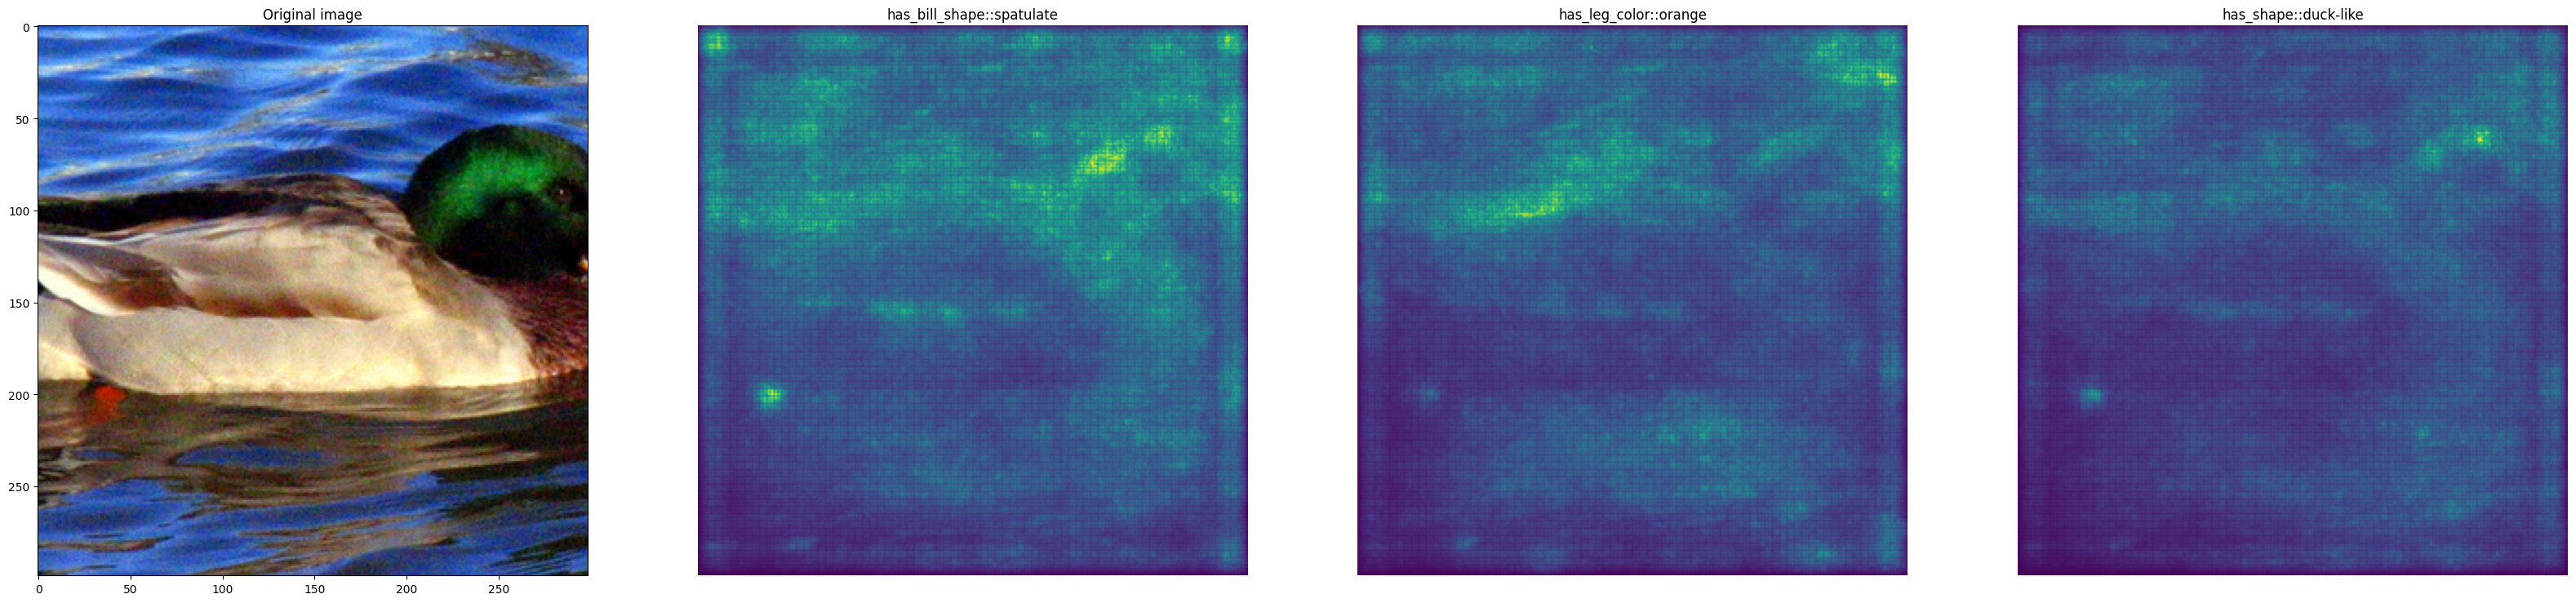

In [16]:
concept_list = [5,273,225]

#Test NoN majority joint model
model_path = r'evaluate_models\Joint_CKPT_NoMajority\best_Joint_model.pth'

#Load the model
Joint_model = torch.load(model_path,map_location=torch.device('cpu'),weights_only=False)
Joint_model.eval()

XtoC_Model = Joint_model.XtoC_model


sailency_maps = get_saliency_maps(X,concept_list,XtoC_Model,method_type='noise_tunnel')

plot_sailency(img,sailency_maps,concept_list,concept_names,coordinates)

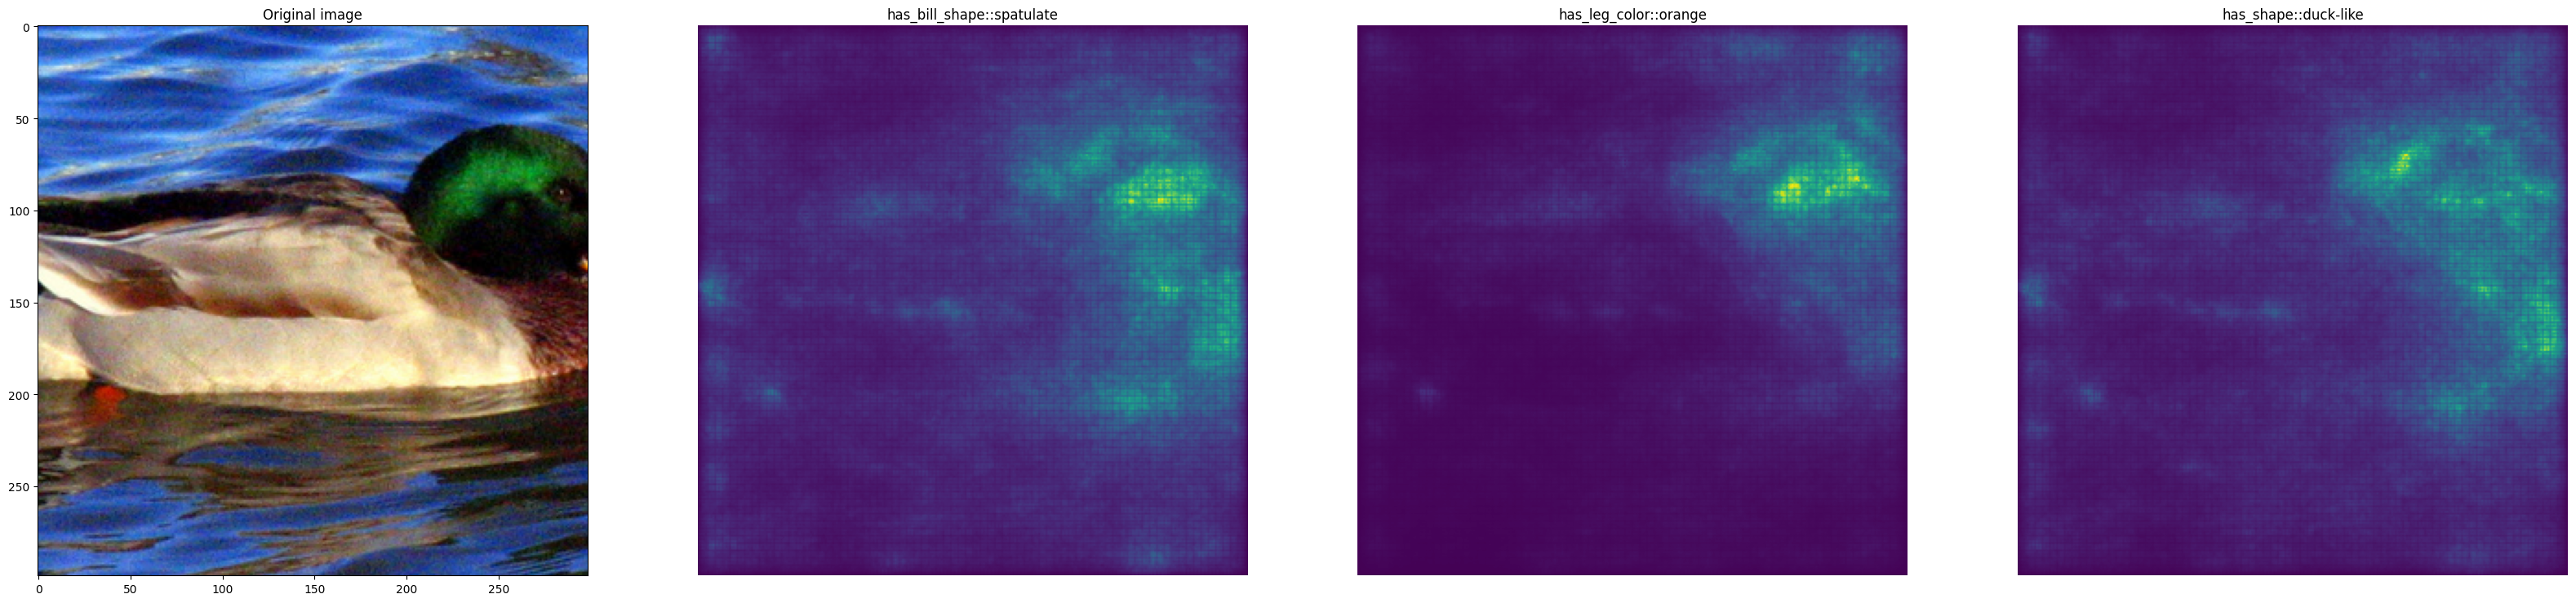

In [11]:
XtoC_Model = torch.load(r'evaluate_models\Concepts_CKPT_NoMajority\best_XtoC_model.pth',map_location=torch.device('cpu'),weights_only=False)
XtoC_Model.eval()
sailency_maps = get_saliency_maps(X,concept_list,XtoC_Model,method_type='noise_tunnel')

plot_sailency(img,sailency_maps,concept_list,concept_names,coordinates)

In [12]:
#print full df
display_scrollable_dataframe(Full_df.sort_values(by=['Concepts'],ascending=False))

In [13]:
print(Selected_df.to_latex(index=False))

\begin{tabular}{lrrrrrrrr}
\toprule
Concept & Label & Majority Label & Joint & Joint weights & Concepts & Independent weights & NoN-MV Label distribution & MV label ditribution \\
\midrule
has_bill_shape::spatulate & True & True & 0.960000 & 1.390000 & 0.630000 & 7.000000 & 0.039786 & 0.020000 \\
has_bill_color::yellow & True & True & 0.510000 & 1.190000 & 0.170000 & 6.000000 & 0.056837 & 0.015000 \\
has_bill_length::about_the_same_as_head & True & True & 0.680000 & 0.340000 & 0.450000 & -1.000000 & 0.362233 & 0.340000 \\
has_forehead_color::green & True & False & 0.250000 & 0.700000 & 0.060000 & 1.000000 & 0.009077 & 0.000000 \\
has_size::medium_(9_-_16_in) & True & True & 0.900000 & 0.650000 & 0.630000 & 0.000000 & 0.196386 & 0.185000 \\
has_shape::duck-like & True & True & 0.930000 & 1.100000 & 0.690000 & 2.000000 & 0.061334 & 0.050000 \\
has_leg_color::orange & False & True & 0.330000 & 1.110000 & 0.110000 & 10.000000 & 0.082881 & 0.045000 \\
has_breast_color::brown & True & True &

In [14]:
display_scrollable_dataframe(Full_df.sort_values(by=['Majority Label',"Label"],ascending=False))

In [15]:
df=pd.DataFrame(Concept_dict).sort_values(by=['Majority Label',"Label"],ascending=False)
latex_table = df.to_latex(index=False)
print(latex_table)

\begin{tabular}{lrrrrrrrr}
\toprule
Concept & Label & Majority Label & Joint & Joint weights & Concepts & Independent weights & NoN-MV Label distribution & MV label ditribution \\
\midrule
has_bill_shape::spatulate & True & True & 0.960000 & 1.390000 & 0.630000 & 7.000000 & 0.039786 & 0.020000 \\
has_wing_color::white & True & True & 0.690000 & 0.240000 & 0.180000 & 1.000000 & 0.260774 & 0.205000 \\
has_upperparts_color::brown & True & True & 0.170000 & 0.070000 & 0.230000 & 5.000000 & 0.243468 & 0.230000 \\
has_upperparts_color::white & True & True & 0.700000 & 0.260000 & 0.190000 & 2.000000 & 0.232949 & 0.175000 \\
has_breast_pattern::solid & True & True & 0.430000 & -0.060000 & 0.470000 & -2.000000 & 0.548269 & 0.645000 \\
has_upper_tail_color::black & True & True & 0.310000 & -0.100000 & 0.250000 & -4.000000 & 0.256956 & 0.305000 \\
has_breast_color::brown & True & True & 0.440000 & 0.740000 & 0.370000 & 8.000000 & 0.113590 & 0.065000 \\
has_eye_color::black & True & True & 0.84000